# Parcial Corte 2 AAD
###### Camila Rayen Nahuel, Mariana Ramírez, Santiago Hoyos


### Análisis Exploratorio de Datos y pre-procesamiento

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
df_train = pd.read_csv('train.csv').dropna(axis=1)
df_train = df_train.drop(columns=['Id','Condition2'])
df_train.head()

MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0          60       RL     8450   Pave      Reg         Lvl    AllPub   
1          20       RL     9600   Pave      Reg         Lvl    AllPub   
2          60       RL    11250   Pave      IR1         Lvl    AllPub   
3          70       RL     9550   Pave      IR1         Lvl    AllPub   
4          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope Neighborhood  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0    Inside       Gtl      CollgCr  ...             0         0           0   
1       FR2       Gtl      Veenker  ...             0         0           0   
2    Inside       Gtl      CollgCr  ...             0         0           0   
3    Corner       Gtl      Crawfor  ...           272         0           0   
4       FR2       Gtl      NoRidge  ...             0         0           0   

   PoolArea  MiscVal  MoSold  YrSold SaleType SaleCondition SalePrice  
0         0        0       2    2008       WD        Normal    208500  
1         0        0       5    2007       WD        Normal    181500  
2         0        0       9    2008       WD        Normal    223500  
3         0        0       2    2006       WD       Abnorml    140000  
4         0        0      12    2008       WD        Normal    250000  

[5 rows x 60 columns]

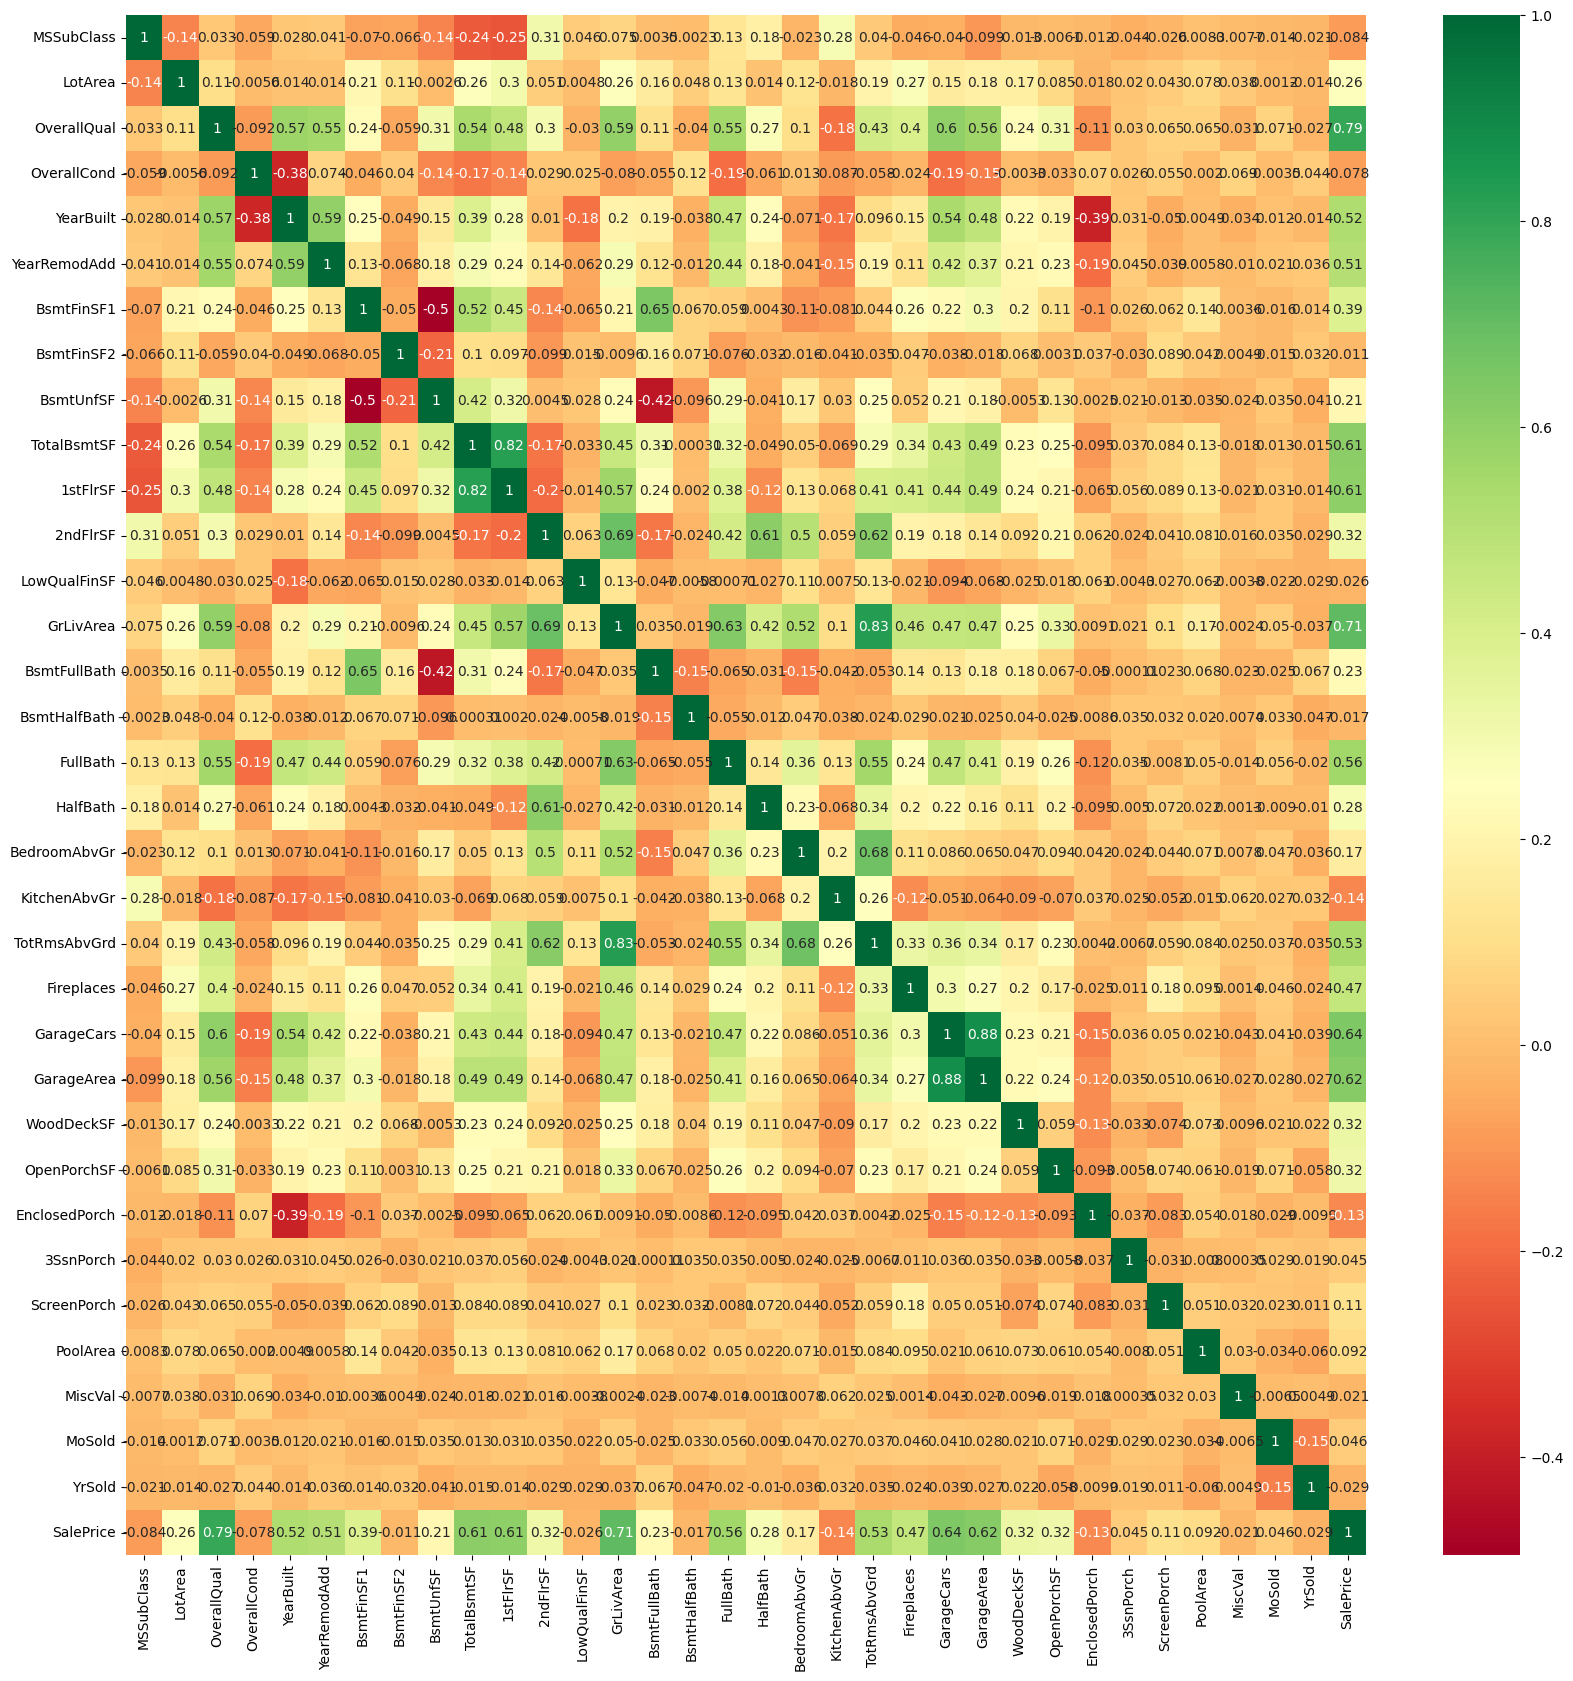

In [3]:
corrmat = df_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Ahora encontremos las variables con mayor correlación con la variable objetivo

In [4]:
corr = df_train.corrwith(df_train['SalePrice'])

corr = corr.abs().sort_values(ascending=False)
top_vars = corr.index[1:6]

for var in top_vars:
    coef = corr[var]
    print(f"{var}: {coef:.2f}")

OverallQual: 0.79
GrLivArea: 0.71
GarageCars: 0.64
GarageArea: 0.62
TotalBsmtSF: 0.61


#### Pruebas de linealidad sin categóricas

In [5]:
y1 = df_train[['SalePrice']]
X1 = df_train.select_dtypes(exclude=['object'])

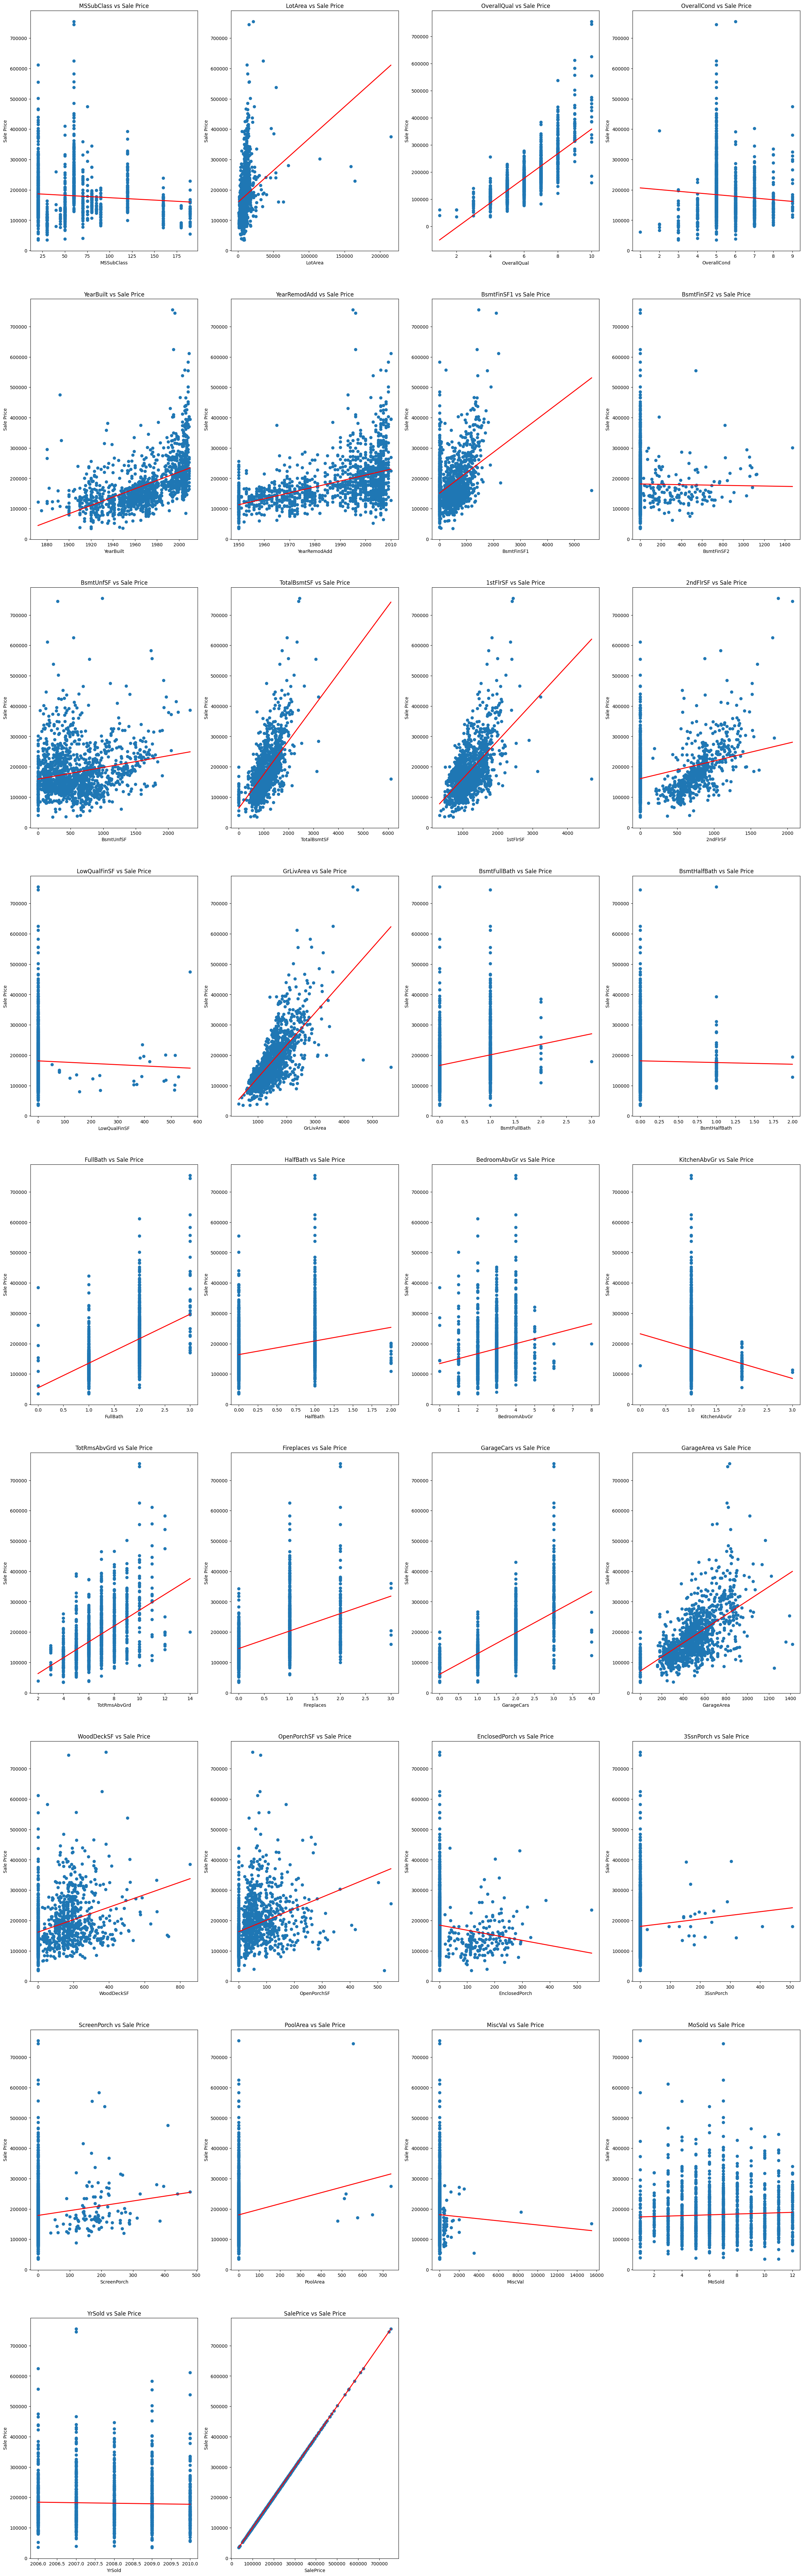

In [6]:
r_squared=[]
# Assuming you have X and y defined before this code block
num_plots = X1.shape[1]
num_cols = 4  # Number of columns of subplots
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 100))

# Flatten the axes array if needed
if num_rows > 1:
    axes = axes.flatten()

# Create plots for each feature
for i, (col_name, col_data) in enumerate(X1.items()):
    ax = axes[i]
    ax.scatter(col_data, y1)
    ax.set_title(f'{col_name} vs Sale Price')
    ax.set_xlabel(col_name)
    ax.set_ylabel('Sale Price')

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(np.array(col_data).reshape(-1, 1), y1)

    # Get the coefficients (slope and intercept)
    slope = model.coef_[0]
    intercept = model.intercept_

    # Plot the linear regression line
    x_range = np.linspace(min(col_data), max(col_data), 1460)
    y_pred = slope * x_range + intercept
    r_squared.append(r2_score(y1, y_pred))
    ax.plot(x_range, y_pred, color='red', linewidth=2)

# Remove any empty subplots
if num_plots < num_rows * num_cols:
    for j in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[j])

# Adjust layout
plt.show()


In [7]:
min(r_squared)

-14.239209334307844

Como podemos ver en las regresiones lineales respecto a Sale Price contra cada variable no categórica, se entiende que debemos escoger la que tiene menor relación lineal con Sale y por lo tanto escogimos year built para aplicarle splines.

## Varibles categóricas con respecto a Sales Price

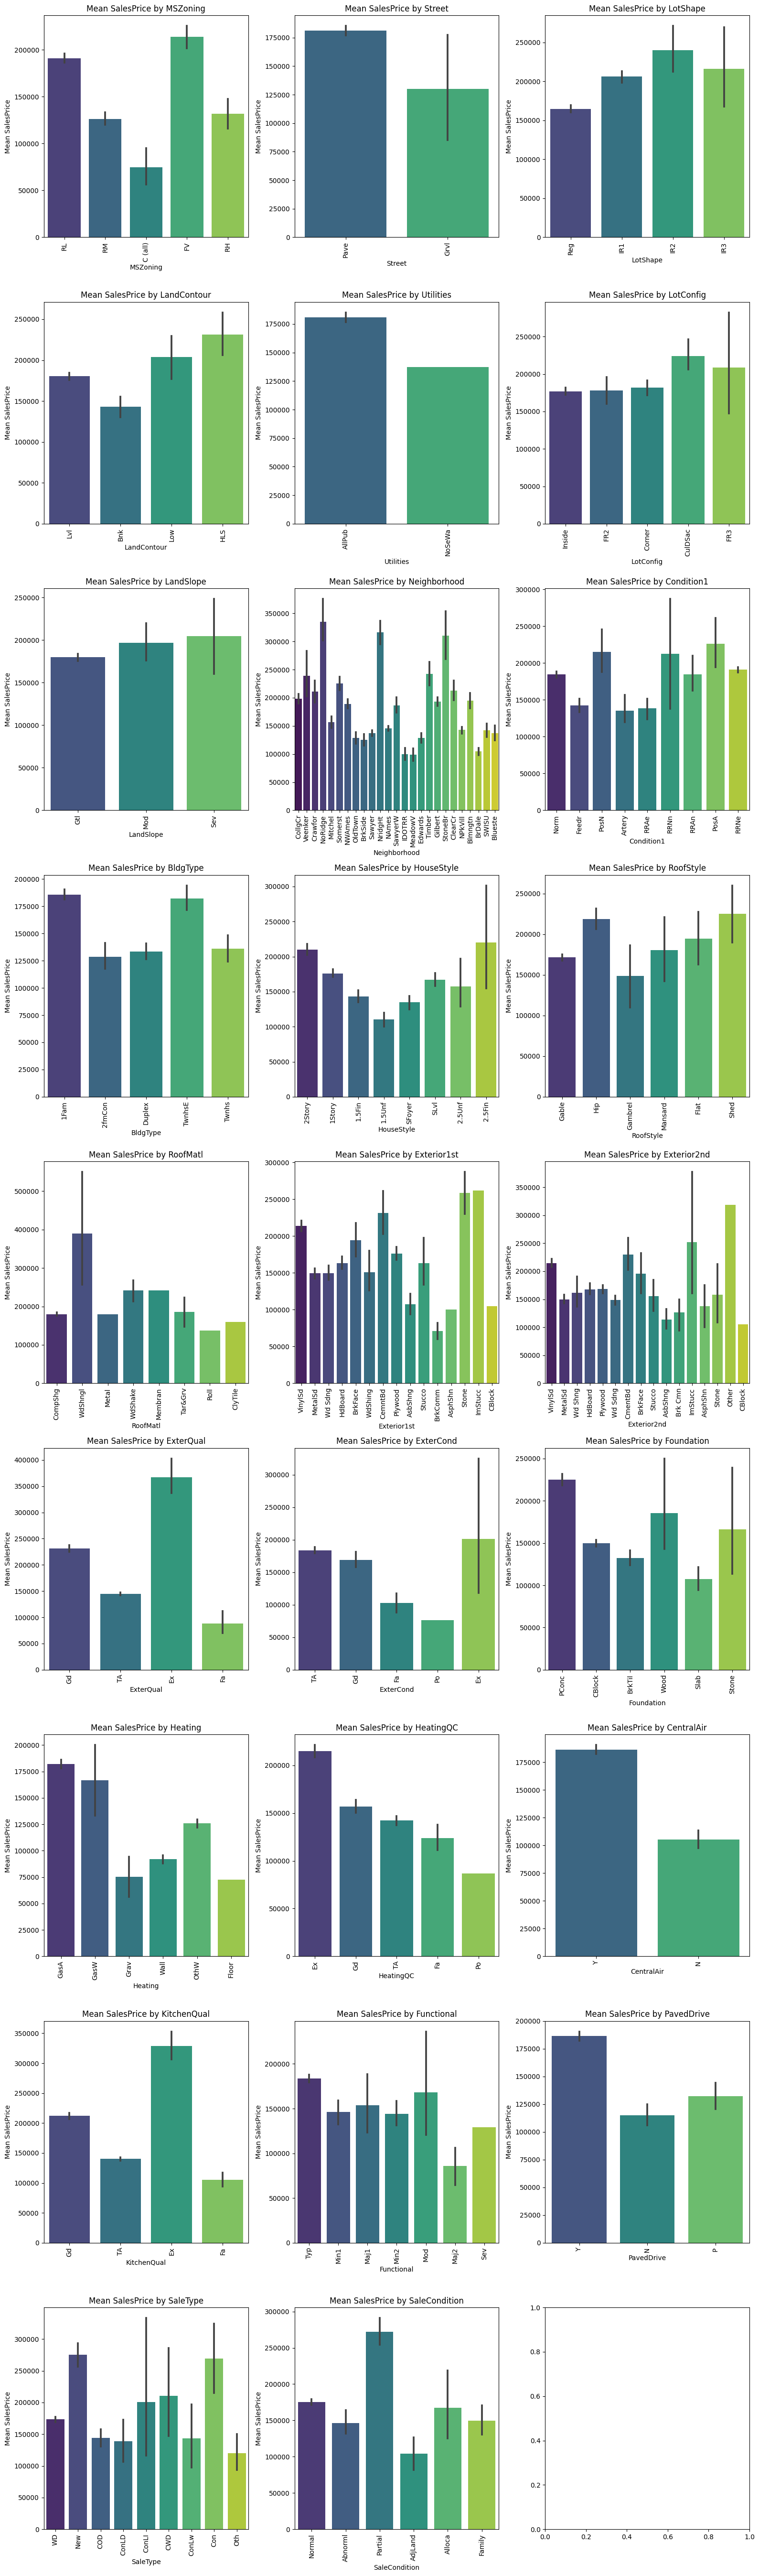

In [8]:
# Select categorical variables
categorical_vars = df_train.select_dtypes(include=['object'])

# Set the number of columns per row
columns_per_row = 3

# Calculate the total number of rows needed
num_rows = math.ceil(len(categorical_vars.columns) / columns_per_row)

# Calculate the total figure size
fig_width = 16
fig_height = 6 * num_rows

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(fig_width, fig_height))

# Ensure that categorical variables are displayed in rows of three
if num_rows == 1:
    axes = [axes]

# Iterate through the categorical variables and create bar plots in the corresponding subplots
for i, column in enumerate(categorical_vars.columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row
    sns.barplot(x=column, y='SalePrice', data=df_train, ax=axes[row_index][col_index], palette='viridis')
    axes[row_index][col_index].set_title(f'Mean SalesPrice by {column}')
    axes[row_index][col_index].tick_params(axis='x', rotation=90)
    axes[row_index][col_index].set_xlabel(column)
    axes[row_index][col_index].set_ylabel('Mean SalesPrice')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()



In [9]:
# Create an empty dictionary to store ANOVA results
anova_results = {}

# Iterate through each categorical variable and perform ANOVA
for column in categorical_vars.columns:
    groups = [df_train[df_train[column] == category]['SalePrice'] for category in df_train[column].unique()]
    f_statistic, p_value = stats.f_oneway(*groups)
    anova_results[column] = {'F-Statistic': f_statistic, 'P-Value': p_value}

# Print the ANOVA results
for column, result in anova_results.items():
    print(f'ANOVA for {column}:')
    print(f'  F-Statistic: {result["F-Statistic"]}')
    print(f'  P-Value: {result["P-Value"]}\n')


ANOVA for MSZoning:
  F-Statistic: 43.84028167245718
  P-Value: 8.817633866272648e-35

ANOVA for Street:
  F-Statistic: 2.4592895583691994
  P-Value: 0.11704860406782483

ANOVA for LotShape:
  F-Statistic: 40.13285166226295
  P-Value: 6.447523852011766e-25

ANOVA for LandContour:
  F-Statistic: 12.850188333283924
  P-Value: 2.7422167521379096e-08

ANOVA for Utilities:
  F-Statistic: 0.29880407484898486
  P-Value: 0.5847167739689381

ANOVA for LotConfig:
  F-Statistic: 7.809954123467792
  P-Value: 3.163167473604189e-06

ANOVA for LandSlope:
  F-Statistic: 1.9588170374149438
  P-Value: 0.1413963584114019

ANOVA for Neighborhood:
  F-Statistic: 71.78486512058272
  P-Value: 1.558600282771154e-225

ANOVA for Condition1:
  F-Statistic: 6.118017137125925
  P-Value: 8.904549416138853e-08

ANOVA for BldgType:
  F-Statistic: 13.011077169620851
  P-Value: 2.0567364604967015e-10

ANOVA for HouseStyle:
  F-Statistic: 19.595000995981223
  P-Value: 3.376776535121222e-25

ANOVA for RoofStyle:
  F-Stat

Por otro lado, podemos ver que con las variables categóricas el los p valores más pequeños son los de Neighborhood y ExterQual. Esto también se corrobora en los barplots. Por lo tanto utilizaremos estas dos para hacer un modelo en kernel para la predicción de Sale Price.

### Spline

Para hacer splines escogimos la carácteristica de Yearbuilt, ya que este tenia una baja relación lineal con la variable objetivo: 'Sale Price'.

Nosotros vamos a utilizar el spline cúbico ya que el final de nuestros datos de la variable X muestra una no linealidad y queremos poder escoger nuestros nodos específicamente para tener un modelo bien ajustado

In [10]:
X1 = X1['YearBuilt']
y1 = y1['SalePrice']

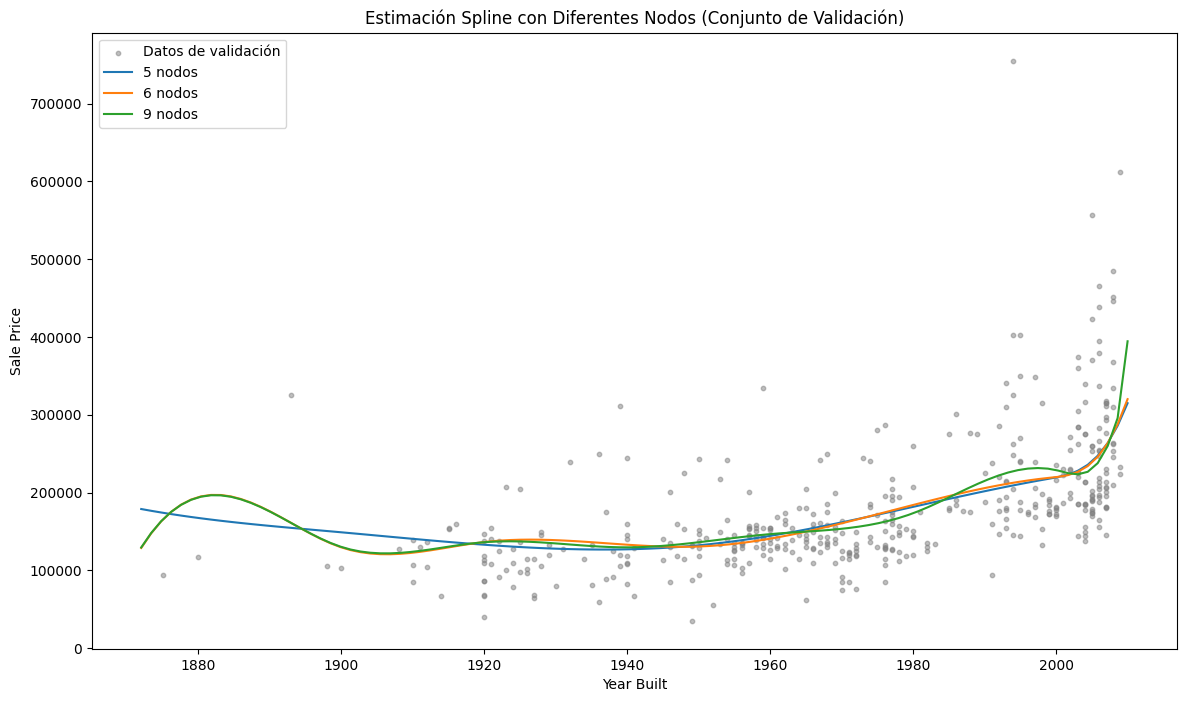

{5: 65687.30953629386, 6: 65409.450865909406, 9: 67317.60164391146}


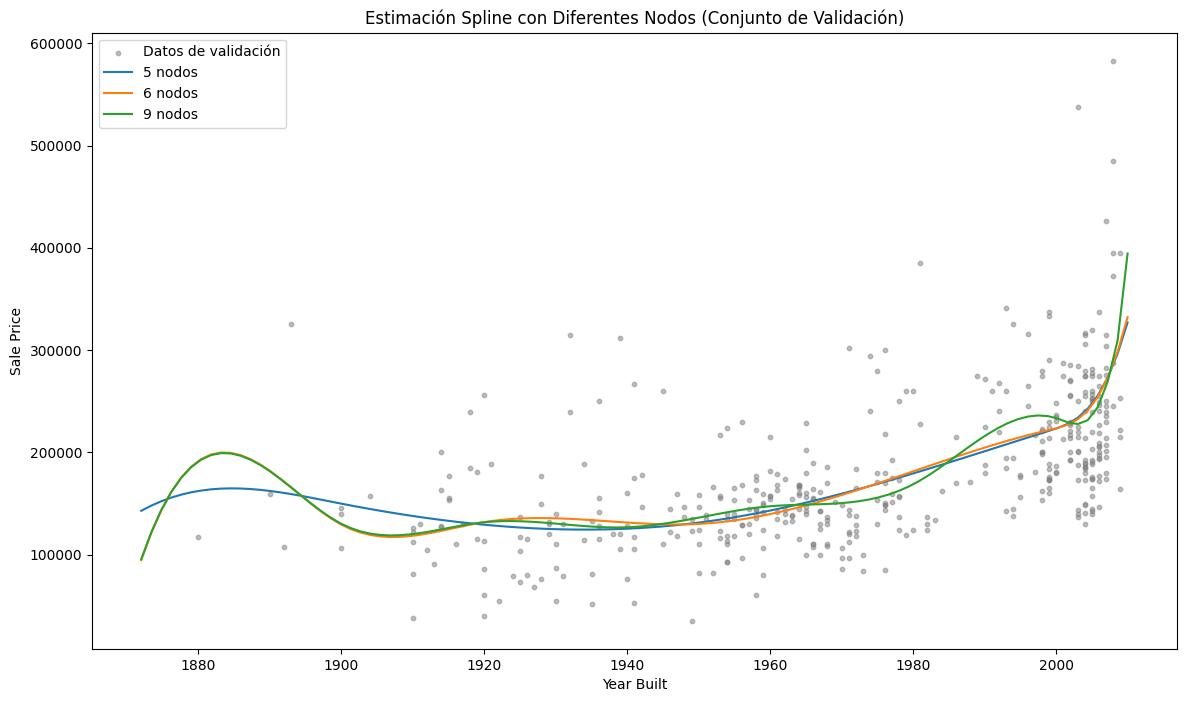

{5: 57822.33874039102, 6: 57585.2079948917, 9: 58400.768401487294}


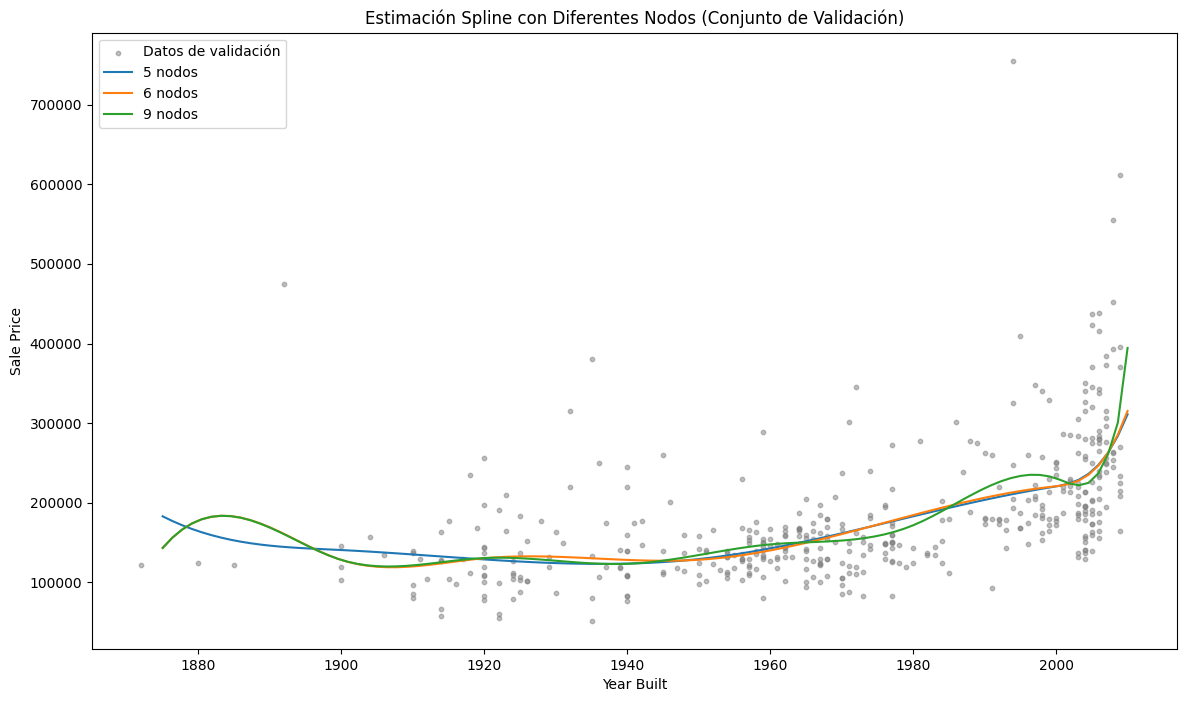

{5: 66177.68174586298, 6: 65783.3338936818, 9: 69215.03171723346}


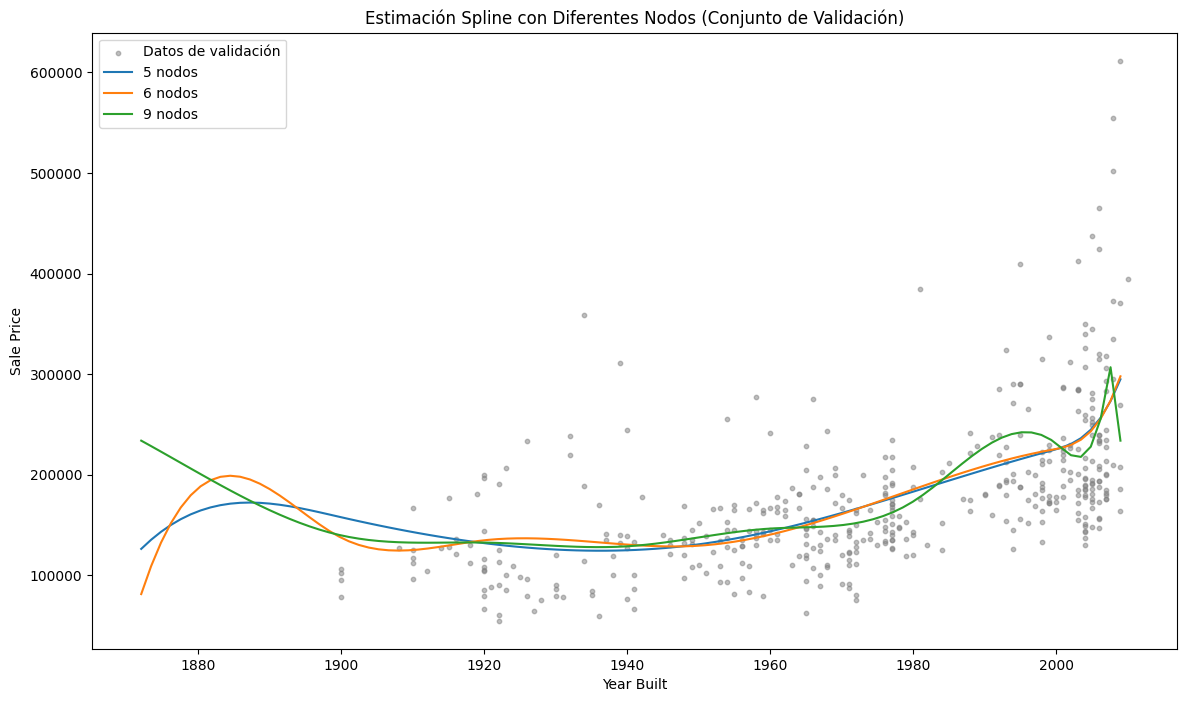

{5: 59917.16015079691, 6: 61394.18641926594, 9: 59655.19193739231}


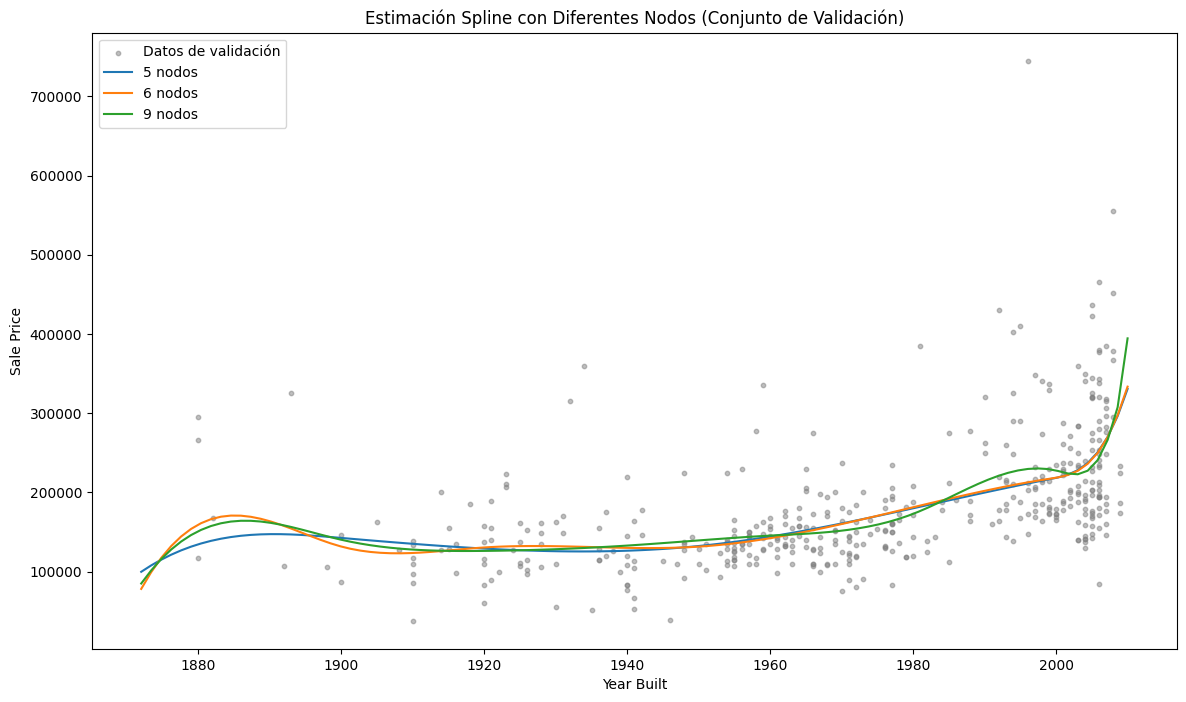

{5: 66690.2182739926, 6: 66729.11605097484, 9: 65517.74107230699}


In [11]:
models=[]
mse = []
for i in range(1,6):
  X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.3, random_state=i*42)
  X_plot = np.linspace(min(X_train), max(X_train), 100).reshape(-1, 1)
  knots_list = [(1900,1950,1999),
                (1900,1920,1950,1999),
                (1900,1920,1940,1960,1980,2000,2009)]

  spline_models = {}
  spline_mse = {}

  plt.figure(figsize=(14, 8))

  plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

  for idx, knots in enumerate(knots_list):
      # Número de nodos
      num_nodes = len(knots) + 2


      # Matriz de diseño
      X_spline_train = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                          {"data": X_train.ravel()}, return_type='dataframe')
      X_spline_val = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                        {"data": X_val.ravel()}, return_type='dataframe')


      # Ajustamos el modelo de regresión lineal
      model_spline = LinearRegression()
      model_spline.fit(X_spline_train, y_train)

      spline_models[num_nodes] = model_spline

      y_spline_val_pred = model_spline.predict(X_spline_val)
      rmse_val = np.sqrt(mean_squared_error(y_val, y_spline_val_pred))

      spline_mse[num_nodes] = rmse_val

      # Graficamos el modelo
      X_spline_plot = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                          {"data": X_plot.ravel()}, return_type='dataframe')

      y_spline_plot = model_spline.predict(X_spline_plot)
      plt.plot(X_plot, y_spline_plot, label=f"{num_nodes} nodos")

  # Etiquetas y título
  plt.xlabel("Year Built")
  plt.ylabel("Sale Price")
  plt.title("Estimación Spline con Diferentes Nodos (Conjunto de Validación)")
  plt.legend()
  plt.show()

  # Mostramos el MSE de validación para cada modelo spline
  print(spline_mse)
  models.append(spline_models)
  mse.append(spline_mse)

In [12]:
mse

[{5: 65687.30953629386, 6: 65409.450865909406, 9: 67317.60164391146},
 {5: 57822.33874039102, 6: 57585.2079948917, 9: 58400.768401487294},
 {5: 66177.68174586298, 6: 65783.3338936818, 9: 69215.03171723346},
 {5: 59917.16015079691, 6: 61394.18641926594, 9: 59655.19193739231},
 {5: 66690.2182739926, 6: 66729.11605097484, 9: 65517.74107230699}]

Haciendo cross validation para nuestro splines vemos que, en general, utilizar 6 nodos es lo mejor ya que nos va los valores mse más bajos. Además, revisando las gráficas si es cierto que es el que más se parece en cada caso.

Sin embargo, es importante decir que los nodos que escogimos fueron a ojo ya que entendiamos los datos con los que estabamos trabajando y donde sería mejor definir un spline.

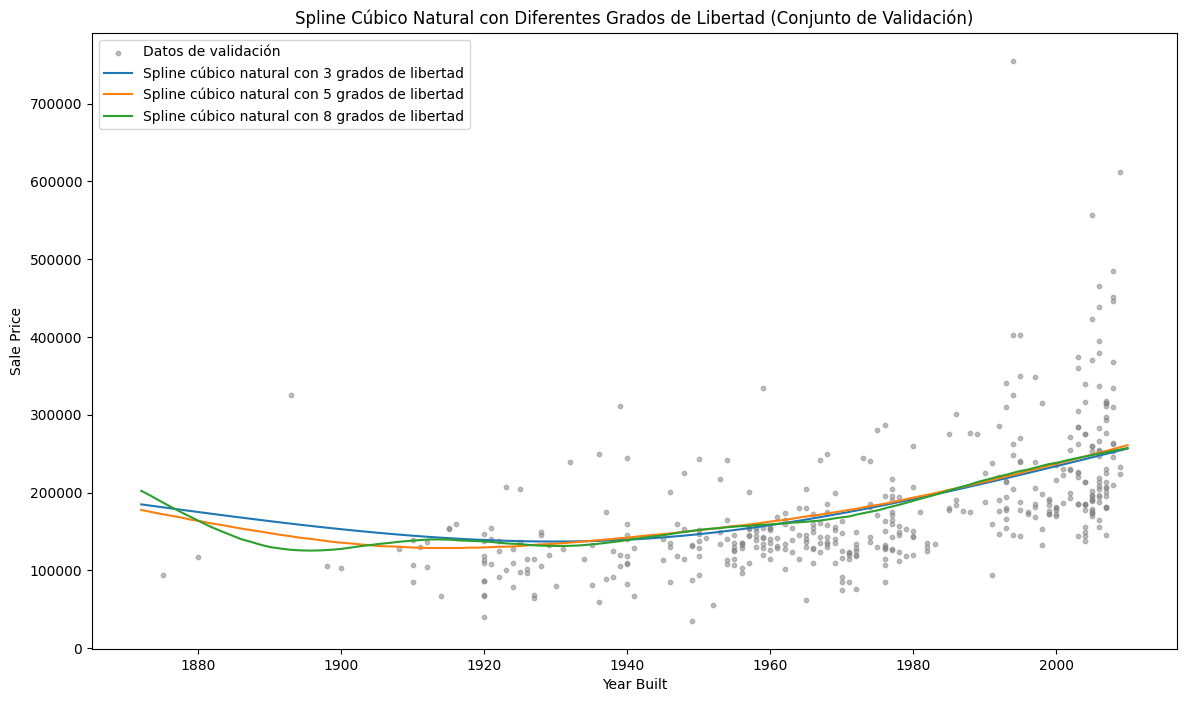

MSE: {3: 66519.33342297208, 5: 66390.95170844762, 8: 66473.97490187951}


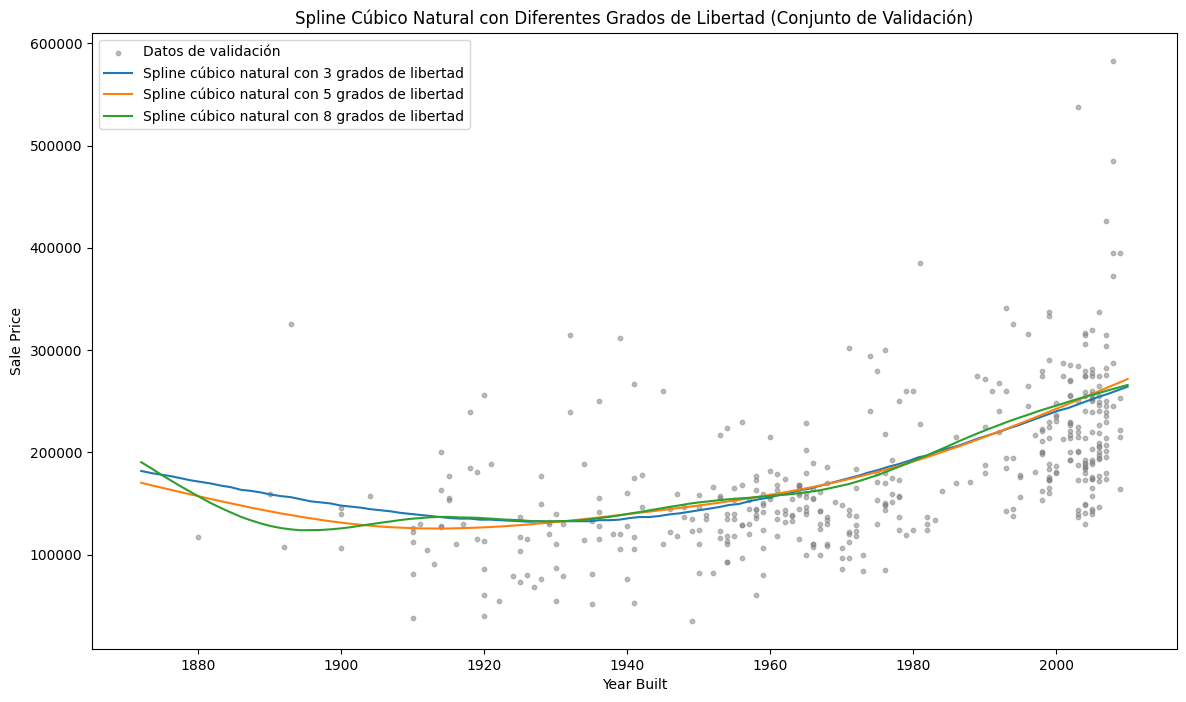

MSE: {3: 58080.81092429141, 5: 58333.39513440301, 8: 58243.6546258935}


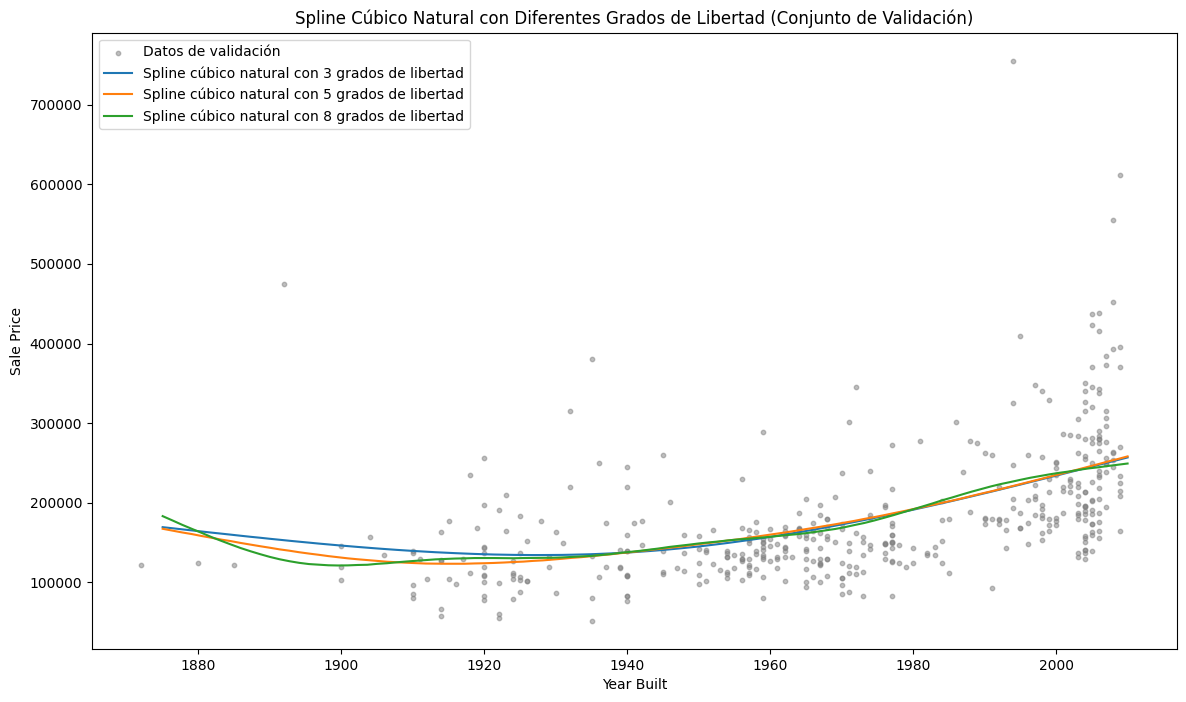

MSE: {3: 67344.9434541316, 5: 67061.92912640712, 8: 67294.68035968616}


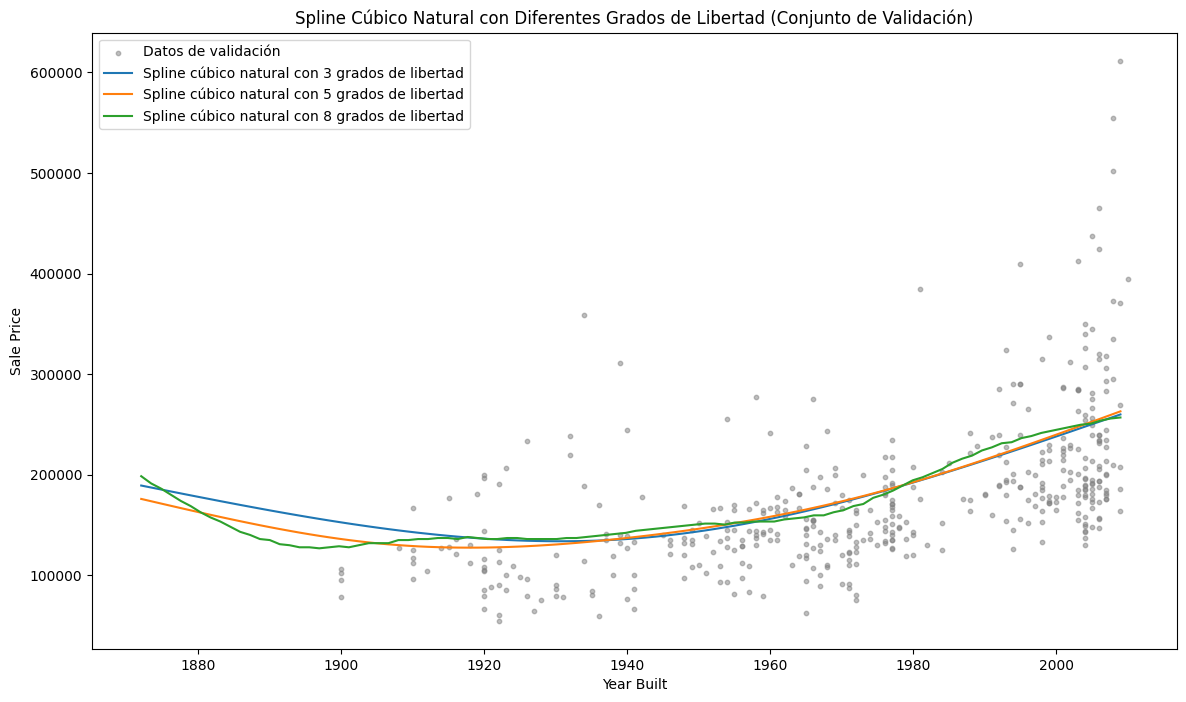

MSE: {3: 60829.21613251977, 5: 60124.85100895731, 8: 60504.70873430291}


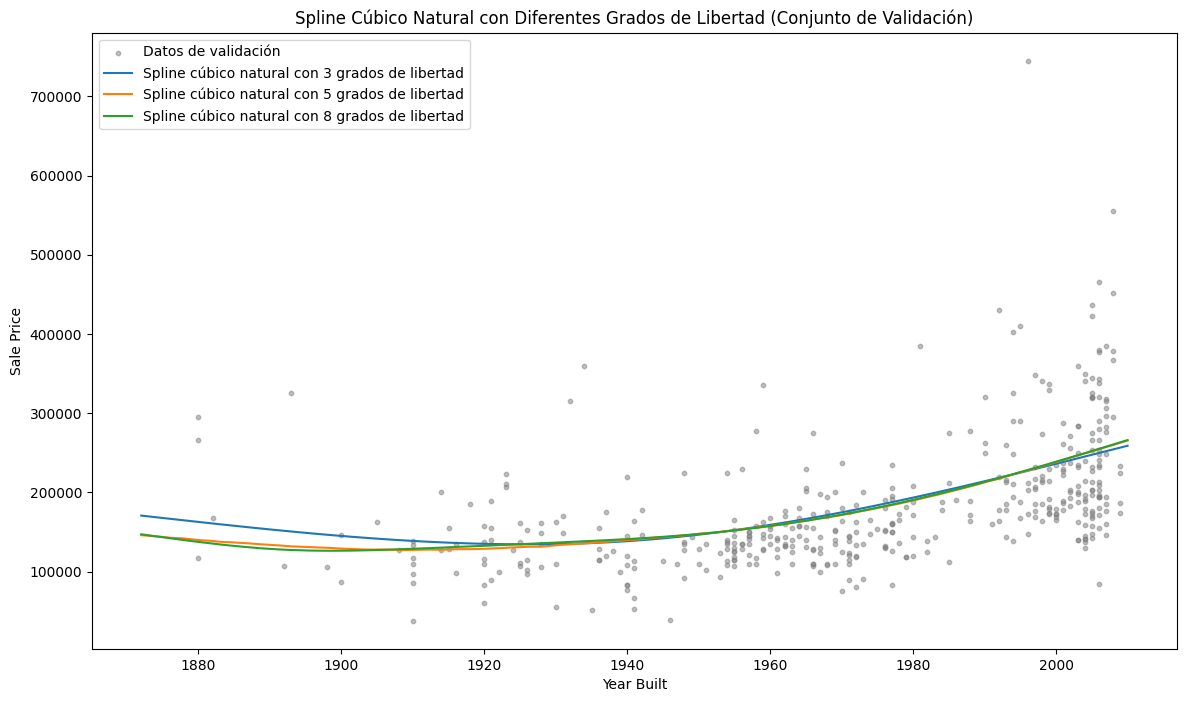

MSE: {3: 65909.98551208456, 5: 66098.05396587211, 8: 66126.00301936714}


In [13]:
mse2=[]
for i in range(1,6):
  X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.3, random_state=i*42)
  X_plot = np.linspace(min(X_train), max(X_train), 100).reshape(-1, 1)


  spline_models = {}
  plt.figure(figsize=(14, 8))

  plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

  natural_spline_mse_es = {}

  knot_colors = {3: 'red', 5: 'green', 8: 'blue'}

  for df in [3, 5, 8]:
      # Crear matriz de diseño para el spline cúbico natural con Patsy
      # Nota: Usamos 'cr()' para el spline cúbico natural y especificamos df (grados de libertad)
      X_spline_train_natural = dmatrix(f"cr(data, df={df})",
                                      {"data": X_train.ravel()}, return_type='dataframe')

      # Ajustar el modelo de regresión lineal
      model_spline_natural = LinearRegression()
      model_spline_natural.fit(X_spline_train_natural, y_train)
      spline_models[df] = model_spline_natural
      # Crear matriz de diseño para el conjunto de gráficos
      X_spline_plot_natural = dmatrix(f"cr(data, df={df})",
                                      {"data": X_plot.ravel()}, return_type='dataframe')

      # Realizar la predicción para el conjunto de gráficos
      y_spline_plot_natural = model_spline_natural.predict(X_spline_plot_natural)

      # Matriz de diseño para el conjunto de validación
      X_spline_val_natural = dmatrix(f"cr(data, df={df})",
                                    {"data": X_val.ravel()}, return_type='dataframe')

      y_spline_val_pred_natural = model_spline_natural.predict(X_spline_val_natural)
      rmse_val_natural = np.sqrt(mean_squared_error(y_val, y_spline_val_pred_natural))


      natural_spline_mse_es[df] = rmse_val_natural

      plt.plot(X_plot, y_spline_plot_natural, label=f"Spline cúbico natural con {df} grados de libertad")

  plt.xlabel("Year Built")
  plt.ylabel("Sale Price")
  plt.title("Spline Cúbico Natural con Diferentes Grados de Libertad (Conjunto de Validación)")
  plt.legend()
  plt.show()

  natural_spline_mse_es

  # Mostramos el MSE de validación para cada modelo spline
  print(f'MSE: {natural_spline_mse_es}')
  mse2.append(natural_spline_mse_es)

Solo para confirmar nuestra conclusión inicial adjuntamos splines naturales y se puede ver claramente que siempre al final no se hace una curva tan definida que es lo que nuestro modelo pide.

#### Mejor modelo con todos los datos

In [14]:
X1 = df_train['YearBuilt']
y1 = df_train['SalePrice']

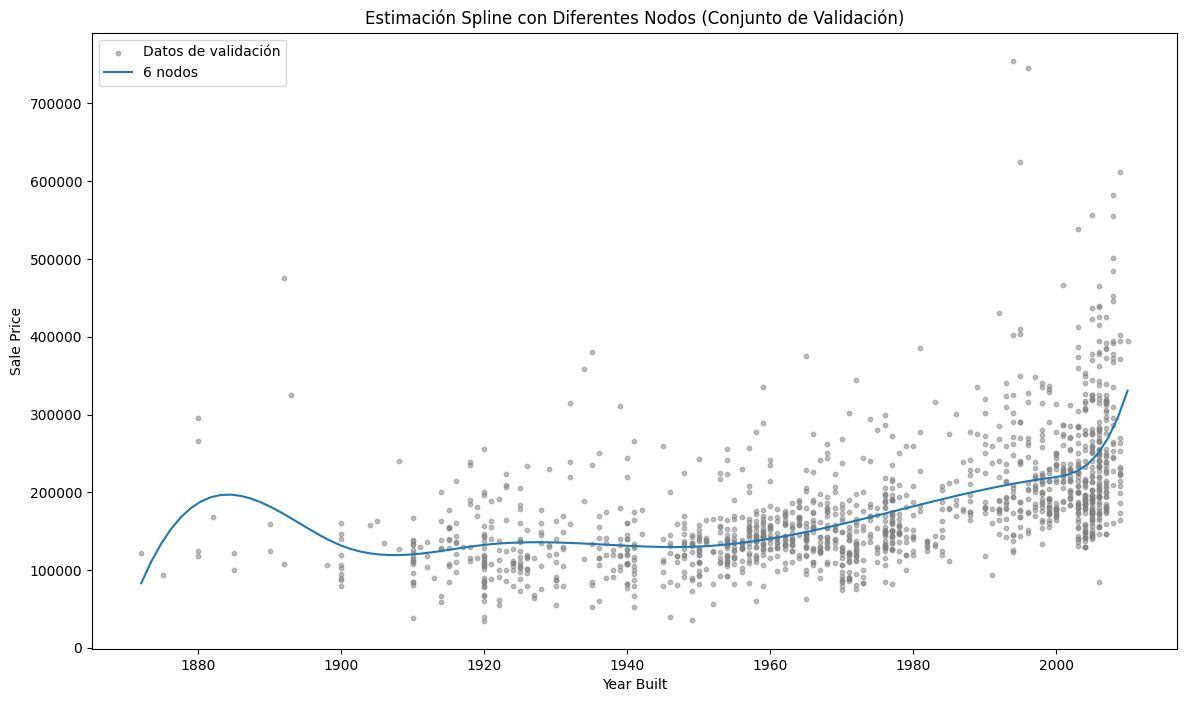

In [15]:

X_plot = np.linspace(min(X1), max(X1), 100).reshape(-1, 1)
knots_list = [(1900,1920,1950,1999)]

spline_models = {}
spline_mse = {}

plt.figure(figsize=(14, 8))

plt.scatter(X1, y1, s=10, color='gray', alpha=0.5, label="Datos de validación")

for idx, knots in enumerate(knots_list):
      # Número de nodos
      num_nodes = len(knots) + 2

      # Matriz de diseño
      X_spline = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                          {"data": X1.ravel()}, return_type='dataframe')

      # Ajustamos el modelo de regresión lineal
      model_spline = models[4][6]
      model_spline.fit(X_spline, y1)

      spline_models[num_nodes] = model_spline

      y_spline_pred = model_spline.predict(X_spline)
      rmse_val = np.sqrt(mean_squared_error(y1, y_spline_pred))

      spline_mse[num_nodes] = rmse_val

      # Graficamos el modelo
      X_spline_plot = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                          {"data": X_plot.ravel()}, return_type='dataframe')

      y_spline_plot = model_spline.predict(X_spline_plot)
      plt.plot(X_plot, y_spline_plot, label=f"{num_nodes} nodos")

# Etiquetas y título
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.title("Estimación Spline con Diferentes Nodos (Conjunto de Validación)")
plt.legend()
plt.show()


In [16]:
print(spline_mse)

{6: 63369.698969157325}


### Kernel

Vamos a hacer kernel de 1 variable para las 3 variables que probablemente predicen mejor Sale Price.

Primero definimos las funciones de kernel que vamos a utilizar que será Epanechnikov ya que esta desprecia un poco menos los vecinos más lejanos del punto en el que estamos parados.

In [17]:
def knn_Epanechnikov(lmbda:float, point:float,
                 data_x:np.ndarray, data_y:np.ndarray) -> float:
    t = np.absolute(data_x-point)/lmbda
    k = np.where(t <= 1, .75*(1-t), 0)
    return (k @ data_y).sum()/k.sum()


Definamos cross validation para las funciones kernel

In [18]:
def kernelCrossVal1(X1_s,y1):
  lmbda = np.linspace(0.01,1,20)
  rmse = {}
  models = []
  errors=[]
  for l in lmbda:
    for i in range(1,6):
      m = {}
      X_train, X_val, y_train, y_val = train_test_split(X1_s, y1, test_size=0.3, random_state=i*42)
      xgrid = X_val

      y_knn_weighted_E = np.array([knn_Epanechnikov(l, x, X_train, y_train)
                                    for x in xgrid])
      y_knn_weighted_E[np.isnan(y_knn_weighted_E)] = 0
      error = np.sqrt(mean_squared_error(y_val,y_knn_weighted_E))
      errors.append(error)

      m['E']=y_knn_weighted_E

    models.append(m)

    rmse[l] = np.mean(errors)
  return rmse,models

Para la variable categórica, Neighborhood, con menor p-valor en anova. Es decir la que probablemente predice mejor Sale Price.



In [19]:
df_train['Neighborhood'] = df_train['Neighborhood'].astype('category').cat.codes
X1 = df_train['Neighborhood']
y1 = df_train['SalePrice']

# Scaling X
s = MinMaxScaler()
X1_s = pd.Series(s.fit_transform(np.array(X1).reshape(-1,1)).flatten())

In [20]:
[rmse,models] = kernelCrossVal1(X1_s,y1)
rmse

{0.01: 53532.217470335345,
 0.06210526315789474: 55858.704163639675,
 0.11421052631578947: 58728.25289791917,
 0.16631578947368422: 61339.878103314004,
 0.21842105263157896: 63714.59584525434,
 0.2705263157894737: 65564.4874057121,
 0.32263157894736844: 66993.99388042465,
 0.37473684210526315: 68101.63625038092,
 0.4268421052631579: 68994.27285178717,
 0.4789473684210527: 69714.95375823486,
 0.5310526315789474: 70314.99505778422,
 0.5831578947368421: 70835.02041705656,
 0.6352631578947369: 71295.52491013109,
 0.6873684210526316: 71703.8676164936,
 0.7394736842105263: 72065.95819402642,
 0.791578947368421: 72389.12310299498,
 0.8436842105263158: 72680.54509555937,
 0.8957894736842106: 72945.30600631956,
 0.9478947368421053: 73186.93427041499,
 1.0: 73408.22985216523}

Con todos los datos para el lambda de error medio más bajo

In [21]:
y_knn_weighted_E = np.array([knn_Epanechnikov(0.01, x, X1_s, y1)
                                    for x in X1_s])
np.sqrt(mean_squared_error(y1,y_knn_weighted_E))

53534.684652657634

Text(0.5, 1.0, 'Epanechnikov Kernel')

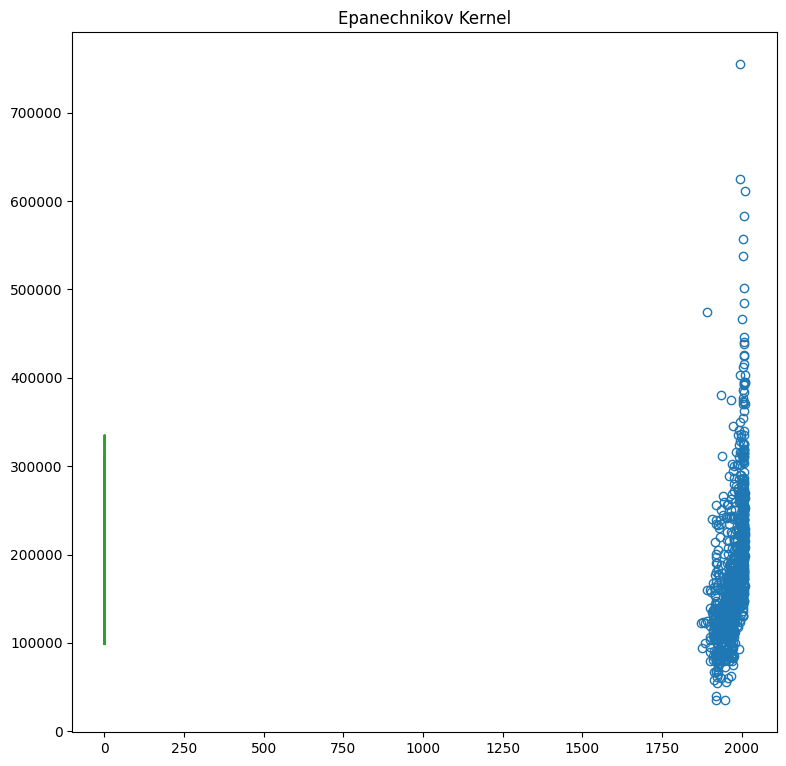

In [22]:
sort_index = np.argsort(X1_s)
X_sorted = X1_s[sort_index]
y_pred_sorted = y_knn_weighted_E[sort_index]

fig61 = plt.figure(61, figsize=(20, 20))
ax2 = fig61.add_subplot(2, 2, 1)
#ax2.plot(xgrid, y_val, color='C0', linewidth=2)
ax2.plot(X_sorted, y_pred_sorted, color='C2')
ax2.plot(X_train, y_train, 'o', color='C0', mfc='none')
#ax2.plot(X_train[mask_neighbor], y_train[mask_neighbor],   'o', color='C3', mfc='none')
ax2.set_title('Epanechnikov Kernel')

Con la variable continua , TotalBsmtSF,de correlación alta

In [23]:
X1 = df_train['TotalBsmtSF']
y1 = df_train['SalePrice']

# Scaling X
s = MinMaxScaler()
X1_s = pd.Series(s.fit_transform(np.array(X1).reshape(-1,1)).flatten())

In [24]:
[rmse3,models3] = kernelCrossVal1(X1_s,y1)
rmse3

{0.01: 65178.66999027826,
 0.06210526315789474: 62778.70264039216,
 0.11421052631578947: 62082.04247323229,
 0.16631578947368422: 62783.62349751339,
 0.21842105263157896: 63902.0779235243,
 0.2705263157894737: 65078.07675501546,
 0.32263157894736844: 66167.20168588663,
 0.37473684210526315: 67135.77100951344,
 0.4268421052631579: 67986.83633521531,
 0.4789473684210527: 68727.48815517485,
 0.5310526315789474: 69372.15694351314,
 0.5831578947368421: 69936.40612797985,
 0.6352631578947369: 70433.41532157444,
 0.6873684210526316: 70874.12530650187,
 0.7394736842105263: 71267.43869341828,
 0.791578947368421: 71620.57344850704,
 0.8436842105263158: 71939.39415084914,
 0.8957894736842106: 72228.69262597802,
 0.9478947368421053: 72492.42003652595,
 1.0: 72733.86232317906}

In [25]:
y_knn_weighted_E = np.array([knn_Epanechnikov(0.114, x, X1_s, y1)
                                    for x in X1_s])
np.sqrt(mean_squared_error(y1,y_knn_weighted_E))

60856.25280389263

Text(0.5, 1.0, 'Epanechnikov Kernel')

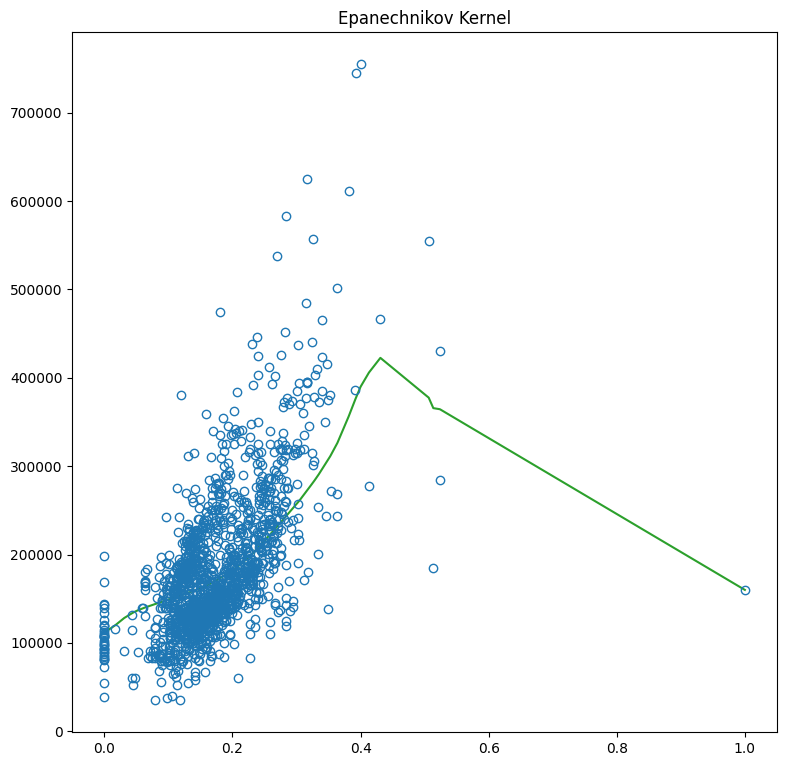

In [26]:
sort_index = np.argsort(X1_s)
X_sorted = X1_s[sort_index]
y_pred_sorted = y_knn_weighted_E[sort_index]

fig61 = plt.figure(61, figsize=(20, 20))
ax2 = fig61.add_subplot(2, 2, 1)
#ax2.plot(xgrid, y_val, color='C0', linewidth=2)
ax2.plot(X_sorted, y_pred_sorted, color='C2')
ax2.plot(X1_s, y1, 'o', color='C0', mfc='none')
#ax2.plot(X_train[mask_neighbor], y_train[mask_neighbor],   'o', color='C3', mfc='none')
ax2.set_title('Epanechnikov Kernel')

Ahora con la variable continua de mayor correlación (0.79) con Sale Price: GrLivArea

In [27]:
X1 = df_train['GrLivArea']
y1 = df_train['SalePrice']

# Scaling X
s = MinMaxScaler()
X1_s = pd.Series(s.fit_transform(np.array(X1).reshape(-1,1)).flatten())

In [28]:
[rmse2,models2] = kernelCrossVal1(X1_s,y1)
rmse2

{0.01: 62247.23832710383,
 0.06210526315789474: 58641.73367443031,
 0.11421052631578947: 58099.95335858119,
 0.16631578947368422: 58365.1118385745,
 0.21842105263157896: 58986.38163701407,
 0.2705263157894737: 59839.26709769357,
 0.32263157894736844: 60809.92802446432,
 0.37473684210526315: 61804.906648636315,
 0.4268421052631579: 62761.73223774584,
 0.4789473684210527: 63653.49318962329,
 0.5310526315789474: 64473.94616342578,
 0.5831578947368421: 65222.49936278509,
 0.6352631578947369: 65903.63684868923,
 0.6873684210526316: 66523.75653302645,
 0.7394736842105263: 67088.08347529177,
 0.791578947368421: 67601.95875268197,
 0.8436842105263158: 68070.93543593396,
 0.8957894736842106: 68500.17753286741,
 0.9478947368421053: 68894.28056843978,
 1.0: 69257.26251181765}

In [29]:
y_knn_weighted_E = np.array([knn_Epanechnikov(0.114, x, X1_s, y1)
                                    for x in X1_s])
np.sqrt(mean_squared_error(y1,y_knn_weighted_E))

54747.082185862695

Text(0.5, 1.0, 'Epanechnikov Kernel')

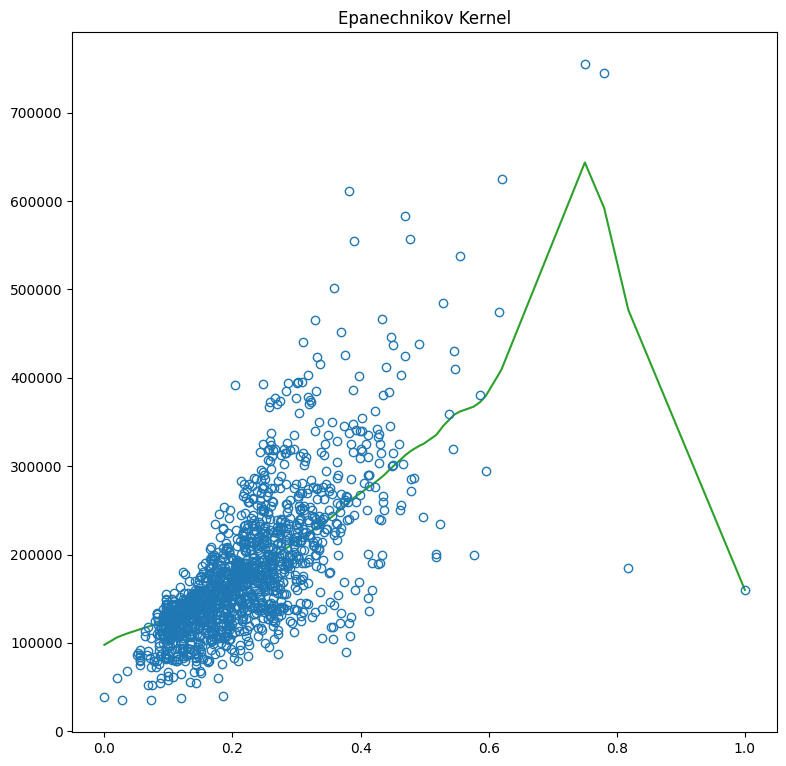

In [30]:
sort_index = np.argsort(X1_s)
X_sorted = X1_s[sort_index]
y_pred_sorted = y_knn_weighted_E[sort_index]

fig61 = plt.figure(61, figsize=(20, 20))
ax2 = fig61.add_subplot(2, 2, 1)
#ax2.plot(xgrid, y_val, color='C0', linewidth=2)
ax2.plot(X_sorted, y_pred_sorted, color='C2')
ax2.plot(X1_s, y1, 'o', color='C0', mfc='none')
#ax2.plot(X_train[mask_neighbor], y_train[mask_neighbor],   'o', color='C3', mfc='none')
ax2.set_title('Epanechnikov Kernel')

Con una única variable nuestros valores de RSME son cercanos a 60000 que es el valor mínimo de la variable SAle price. Ahora veamos para 2 variables

#### Con dos variables

Definimos las funciones kernel para dos variables y nuestra función de cross validation

In [31]:
def distEu(x1,x2):
  return np.sqrt((x1**2) + (x2**2))

# Creamos una funcion para Epanechnikov
def knn_Epanechnikov(lmbda:float, point1:float, point2:float,
                 data_x:np.ndarray, data_y:np.ndarray) -> float:
    # Calculo de la distancia Normalizada
    t1 = np.absolute(data_x[:,0]-point1)/lmbda
    t2 = np.absolute(data_x[:,1]-point2)/lmbda
    t = distEu(t1,t2)
    #aplicacion del kernel Epanechnikov
    k = np.where(t <= 1, .75*(1-t), 0)
    return (k @ data_y).sum()/k.sum()

In [32]:
def kernelCrossVal1(X1_s,y1):
  lmbda = np.linspace(0.01,1,20)
  rmse = {}
  models = []
  errors=[]
  for l in lmbda:
    for i in range(1,6):
      m = {}
      X_train, X_val, y_train, y_val = train_test_split(X1_s, y1, test_size=0.3, random_state=i*42)
      # toca scale adentro porque sino las dimensiones no cuadran
      s = MinMaxScaler()
      X1_train_s = s.fit_transform(np.array(X_train))
      X1_val_s = s.fit_transform(np.array(X_val))

      xgrid = X1_val_s

      y_knn_weighted_E = np.array([knn_Epanechnikov(l, x1,x2, X1_train_s, y_train)
                                  for x1,x2 in xgrid])
      y_knn_weighted_E[np.isnan(y_knn_weighted_E)] = 0
      error = np.sqrt(mean_squared_error(y_val,y_knn_weighted_E))
      errors.append(error)

      m['E']=y_knn_weighted_E

    models.append(m)

    rmse[l] = np.mean(errors)
  return rmse,models

In [33]:
X2 = df_train[['OverallQual','Neighborhood']]

In [34]:
[rmse4,models4] = kernelCrossVal1(X2,y1)
rmse4

{0.01: 127629.35036341655,
 0.06210526315789474: 86949.3513362704,
 0.11421052631578947: 71979.85861797653,
 0.16631578947368422: 64823.42367693076,
 0.21842105263157896: 60717.01628794821,
 0.2705263157894737: 58469.141035984285,
 0.32263157894736844: 57220.99253655651,
 0.37473684210526315: 56684.66408088867,
 0.4268421052631579: 56614.15101650303,
 0.4789473684210527: 56824.976366976305,
 0.5310526315789474: 57234.12523852852,
 0.5831578947368421: 57754.84991200824,
 0.6352631578947369: 58352.06968410285,
 0.6873684210526316: 58981.28112249608,
 0.7394736842105263: 59618.173898617264,
 0.791578947368421: 60245.827625277336,
 0.8436842105263158: 60855.066598942525,
 0.8957894736842106: 61440.84968287764,
 0.9478947368421053: 62000.446585014295,
 1.0: 62532.72882898305}

In [35]:
s = MinMaxScaler()
X2_s = s.fit_transform(np.array(X2))

y_knn_weighted_E = np.array([knn_Epanechnikov(0.4268, x1,x2, X2_s, y1)
                                  for x1,x2 in X2_s])
np.sqrt(mean_squared_error(y1,y_knn_weighted_E))

56503.18857680187

Vemos que con 2 variables la predicción no mejora significativamente

Con solo continuas pero 2 variables

In [36]:
X2 = df_train[['GrLivArea','TotalBsmtSF']]

In [37]:
[rmse5,models5] = kernelCrossVal1(X2,y1)
rmse5

{0.01: 188212.12393171716,
 0.06210526315789474: 182247.065327877,
 0.11421052631578947: 175941.1176259863,
 0.16631578947368422: 166723.86569985707,
 0.21842105263157896: 156168.09719196093,
 0.2705263157894737: 146092.63263137147,
 0.32263157894736844: 137465.24790141216,
 0.37473684210526315: 130094.00947728245,
 0.4268421052631579: 123902.37922851526,
 0.4789473684210527: 118490.9540018412,
 0.5310526315789474: 113918.44369686137,
 0.5831578947368421: 110026.41575012336,
 0.6352631578947369: 106731.51511629681,
 0.6873684210526316: 103929.99331556473,
 0.7394736842105263: 101559.43146652379,
 0.791578947368421: 99560.94368307445,
 0.8436842105263158: 97872.16899091251,
 0.8957894736842106: 96441.0830851518,
 0.9478947368421053: 95217.42172882044,
 1.0: 94157.86478646386}

Tenemos que agregar valores de lambda mayores ya que sigue disminuyendo

In [38]:
def kernelCrossVal1(X1_s,y1):
  lmbda = np.linspace(1,10,20)
  rmse = {}
  models = []
  errors=[]
  for l in lmbda:
    for i in range(1,6):
      m = {}
      X_train, X_val, y_train, y_val = train_test_split(X1_s, y1, test_size=0.3, random_state=i*42)
      # toca scale adentro porque sino las dimensiones no cuadran
      s = MinMaxScaler()
      X1_train_s = s.fit_transform(np.array(X_train))
      X1_val_s = s.fit_transform(np.array(X_val))

      xgrid = X1_val_s

      y_knn_weighted_E = np.array([knn_Epanechnikov(l, x1,x2, X1_train_s, y_train)
                                  for x1,x2 in xgrid])
      y_knn_weighted_E[np.isnan(y_knn_weighted_E)] = 0
      error = np.sqrt(mean_squared_error(y_val,y_knn_weighted_E))
      errors.append(error)

      m['E']=y_knn_weighted_E

    models.append(m)

    rmse[l] = np.mean(errors)
  return rmse,models

In [39]:
[rmse5,models5] = kernelCrossVal1(X2,y1)
rmse5

{1.0: 74026.28288168882,
 1.4736842105263157: 75331.220957114,
 1.9473684210526314: 75986.28791742337,
 2.4210526315789473: 76395.16399048224,
 2.894736842105263: 76679.79660634535,
 3.3684210526315788: 76891.57459858566,
 3.8421052631578947: 77056.43054478518,
 4.315789473684211: 77189.04551260146,
 4.789473684210526: 77298.42738381022,
 5.263157894736842: 77390.44374987228,
 5.7368421052631575: 77469.09793801467,
 6.2105263157894735: 77537.22439138006,
 6.684210526315789: 77596.89175194217,
 7.157894736842105: 77649.64846943774,
 7.63157894736842: 77696.67876273813,
 8.105263157894736: 77738.90515570248,
 8.578947368421051: 77777.0579187589,
 9.052631578947368: 77811.72331973724,
 9.526315789473683: 77843.37791048487,
 10.0: 77872.41337688213}

In [40]:
s = MinMaxScaler()
X2_s = s.fit_transform(np.array(X2))

y_knn_weighted_E = np.array([knn_Epanechnikov(1, x1,x2, X2_s, y1)
                                  for x1,x2 in X2_s])
np.sqrt(mean_squared_error(y1,y_knn_weighted_E))

76573.22700390055

Con solo las continuas vemos que los valores RMSE son mayores que con solo las categóricas. Unamos todas estas respuestas en un kernel de 4 variables.

#### Con 4 variables

In [41]:
def distEu(x1,x2,x3,x4):
  return np.sqrt((x1**2) + (x2**2)+ (x3**2)+ (x4**2))

# Creamos una funcion para Epanechnikov
def knn_Epanechnikov(lmbda:float, point1:float, point2:float,point3:float,point4:float,
                 data_x:np.ndarray, data_y:np.ndarray) -> float:
    # Calculo de la distancia Normalizada
    t1 = np.absolute(data_x[:,0]-point1)/lmbda
    t2 = np.absolute(data_x[:,1]-point2)/lmbda
    t3 = np.absolute(data_x[:,2]-point3)/lmbda
    t4 = np.absolute(data_x[:,3]-point4)/lmbda
    t = distEu(t1,t2,t3,t4)
    #aplicacion del kernel Epanechnikov
    k = np.where(t <= 1, .75*(1-t), 0)
    return (k @ data_y).sum()/k.sum()

def Knn_Gaussian(lmbda:float, point1:float, point2:float,point3:float,point4:float,
                 data_x:np.ndarray, data_y:np.ndarray) -> float:
    t1 = np.absolute(data_x[:,0]-point1)/lmbda
    t2 = np.absolute(data_x[:,1]-point2)/lmbda
    t3 = np.absolute(data_x[:,2]-point3)/lmbda
    t4 = np.absolute(data_x[:,3]-point4)/lmbda
    t = distEu(t1,t2,t3,t4)
    k = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * t**2)
    return (k @ data_y) / k.sum()

In [42]:
def kernelCrossVal1(X1_s,y1):
  lmbda = np.linspace(0.5,5,20)
  rmse = {}
  models = []
  errors=[]
  for l in lmbda:
    for i in range(1,6):
      m = {}
      X_train, X_val, y_train, y_val = train_test_split(X1_s, y1, test_size=0.3, random_state=i*42)
      # toca scale adentro porque sino las dimensiones no cuadran
      s = MinMaxScaler()
      X1_train_s = s.fit_transform(np.array(X_train))
      X1_val_s = s.fit_transform(np.array(X_val))

      xgrid = X1_val_s

      y_knn_weighted_E = np.array([knn_Epanechnikov(l, x1,x2,x3,x4, X1_train_s, y_train)
                                  for x1,x2,x3,x4 in xgrid])
      y_knn_weighted_E[np.isnan(y_knn_weighted_E)] = 0
      error = np.sqrt(mean_squared_error(y_val,y_knn_weighted_E))
      errors.append(error)

      m['E']=y_knn_weighted_E

    models.append(m)

    rmse[l] = np.mean(errors)
  return rmse,models

In [43]:
X4 = df_train[['GrLivArea','TotalBsmtSF','OverallQual','Neighborhood']]

In [44]:
[rmse6,models6] = kernelCrossVal1(X4,y1)
rmse6

{0.5: 55995.947634813005,
 0.7368421052631579: 55541.21269860722,
 0.9736842105263157: 58929.57437260465,
 1.2105263157894737: 62071.501299155854,
 1.4473684210526314: 64419.396289347365,
 1.6842105263157894: 66173.6066318948,
 1.9210526315789473: 67524.65549823495,
 2.1578947368421053: 68596.15101052719,
 2.394736842105263: 69467.14954490519,
 2.631578947368421: 70189.7324948595,
 2.8684210526315788: 70799.41036638801,
 3.1052631578947367: 71321.17604197338,
 3.3421052631578947: 71773.11784154415,
 3.5789473684210527: 72168.648701255,
 3.81578947368421: 72517.92702947433,
 4.052631578947368: 72828.78983604693,
 4.289473684210526: 73107.38225719739,
 4.526315789473684: 73358.59259069698,
 4.763157894736842: 73586.35945841714,
 5.0: 73793.8928994991}

In [45]:
s = MinMaxScaler()
X4_s = s.fit_transform(np.array(X4))

y_knn_weighted_E = np.array([knn_Epanechnikov(0.7368421, x1,x2,x3,x4, X4_s, y1)
                                  for x1,x2,x3,x4 in X4_s])
np.sqrt(mean_squared_error(y1,y_knn_weighted_E))

65363.285398026295

Comparando todos los modelos de kernel, los modelos de solo una variable son los mejores, con las de las categóricas teniendo los mejores errores.

El modelo de kernel con las dos variable categóricas tiene un error bastante cercano al mínimo de los errores por lo que también se considera un buen modelo.

La combinación de todas estas variables da un modelo con un error no tan alto.

### Análisis de los dos modelos




*  El modelo del spline nos da error rsme bastante similar a los errores que vemos en kernel, sin embargo, es bastante más alto que cualquier otro de kernel.

*  A diferencia del spline, como utilizamos multiples variables (además de categóricas) en los modelos por kernel, la visualización de estos es muy complicada y hasta imposible y solo nos podemos guiar de los errores.

*  En splines nos guiamos más de como se ven los resultados para poder escoger entre el tipo de splines que utilizamos, mientras que en kernel nos enfocamos más en los valores que obtenemos para escoger el lambda y otras variables.
